 ##  0. Importing Packages

In [3]:
%run import_modules.py 
import warnings
import time
import pandas as pd
import numpy as np
import os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


import matplotlib.pylab as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#tf.logging.set_verbosity(tf.logging.ERROR)
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#from tensorflow import set_random_seed         ##tf.random.set_seed(1)
import keras 
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

from scipy.stats.mstats import gmean
from scipy.stats import iqr

In [4]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data


## 1. Reading Data

In [5]:
myseed = 56 #anchoring

df_train = pd.read_csv('X_train.csv', encoding='cp949') #F5
df_test = pd.read_csv('X_test.csv', encoding='cp949')
f_data = pd.concat([df_train, df_test]).reset_index(drop=True)

y_train = pd.read_csv('y_train.csv').gender # y_train
IDtest = pd.read_csv('X_test.csv', encoding='cp949').cust_id.unique() #target ID for prediction

## 2. Feature Generation (Word2Vec)

In [6]:
goods_list = []
for i in range(3500):
    goods_pur_order = []
    tmp = df_train[df_train['cust_id']==i]
    for j in range(len(tmp)):
        goods_pur_order.append(tmp.iloc[j,4])
    goods_list.append(goods_pur_order)
    
goods_list2 = []
for i in range(2482):
    goods_pur_order = []
    tmp = df_test[df_test['cust_id']==3500+i]
    for j in range(len(tmp)):
        goods_pur_order.append(tmp.iloc[j,4])
    goods_list2.append(goods_pur_order)  

In [14]:
# * W2V을 이용한 feature 이용하여 생성(min,max,mean,sum,std)
# * train과 test 데이터를 합하여 W2V 학습

### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

train_x = list(df_train.groupby('cust_id')[p_level].agg(oversample, 20))
test_x = list(df_test.groupby('cust_id')[p_level].agg(oversample, 20))
F_data = list(f_data.groupby('cust_id')[p_level].agg(oversample,20))

### Training the Word2Vec model
num_features = 50 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(F_data, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=myseed, workers=6, sg=0)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

In [15]:
### Make features
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.sum([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                iqr([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean(cosine_similarity([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)]))
            ]) 
            for words in X
        ]) 

emb = EmbeddingVectorizer(w2v.wv)
emb.fit(train_x,y_train)

X_train = emb.transform(goods_list)
X_test = emb.transform(goods_list2)
X_train.shape, X_test.shape

((3500, 301), (2482, 301))

In [9]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data


In [10]:
X2_train = pd.read_csv('W2V_train.csv', encoding='cp949') #F5
X2_test = pd.read_csv('W2V_test.csv', encoding='cp949')

X2_train.shape, X2_test.shape

((3500, 501), (2482, 501))

## 3. Build Models

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_151 (Dense)               (None, 128)          38656       input_31[0][0]                   
__________________________________________________________________________________________________
dropout_61 (Dropout)            (None, 128)          0           dense_151[0][0]                  
__________________________________________________________________________________________________
dense_152 (Dense)               (None, 128)          16512       dropout_61[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 24us/step - loss: 0.6962 - acc: 0.7264 - auc_30: 0.7336 - val_loss: 0.7137 - val_acc: 0.7114 - val_auc_30: 0.7341
Epoch 33/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6826 - acc: 0.7325 - auc_30: 0.7349 - val_loss: 0.7102 - val_acc: 0.7029 - val_auc_30: 0.7354
Epoch 34/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6844 - acc: 0.7268 - auc_30: 0.7358 - val_loss: 0.7143 - val_acc: 0.6943 - val_auc_30: 0.7363
Epoch 35/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6788 - acc: 0.7293 - auc_30: 0.7369 - val_loss: 0.7048 - val_acc: 0.7014 - val_auc_30: 0.7373
Epoch 36/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6723 - acc: 0.7250 - auc_30: 0.7379 - val_loss: 0.6990 - val_acc: 0.6971 - val_auc_30: 0.7383
Epoch 37/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6737 - acc: 0.7261 - auc_30: 0.7388 - val_loss: 0.69

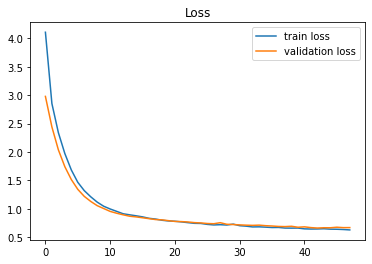

AUC 0.7607540061414599


 10%|████████▎                                                                          | 1/10 [00:06<00:56,  6.27s/it]

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_156 (Dense)               (None, 128)          38656       input_32[0][0]                   
__________________________________________________________________________________________________
dropout_63 (Dropout)            (None, 128)          0           dense_156[0][0]                  
__________________________________________________________________________________________________
dense_157 (Dense)               (None, 128)          16512       dropout_63[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 23us/step - loss: 0.6585 - acc: 0.7286 - auc_31: 0.7441 - val_loss: 0.6771 - val_acc: 0.7129 - val_auc_31: 0.7446
Epoch 33/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6601 - acc: 0.7304 - auc_31: 0.7451 - val_loss: 0.6691 - val_acc: 0.7157 - val_auc_31: 0.7456
Epoch 34/1000
2800/2800 [==============================] - 0s 25us/step - loss: 0.6620 - acc: 0.7250 - auc_31: 0.7460 - val_loss: 0.6782 - val_acc: 0.7157 - val_auc_31: 0.7463
Epoch 35/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6526 - acc: 0.7304 - auc_31: 0.7466 - val_loss: 0.6633 - val_acc: 0.7171 - val_auc_31: 0.7471
Epoch 36/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6431 - acc: 0.7296 - auc_31: 0.7475 - val_loss: 0.6712 - val_acc: 0.7071 - val_auc_31: 0.7479
Epoch 37/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6433 - acc: 0.7275 - auc_31: 0.7483 - val_loss: 0.65

2800/2800 [==============================] - 0s 22us/step - loss: 0.5716 - acc: 0.7229 - auc_31: 0.7650 - val_loss: 0.6051 - val_acc: 0.7071 - val_auc_31: 0.7650
Epoch 79/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5810 - acc: 0.7164 - auc_31: 0.7651 - val_loss: 0.6023 - val_acc: 0.7029 - val_auc_31: 0.7651
Epoch 80/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5632 - acc: 0.7421 - auc_31: 0.7652 - val_loss: 0.5960 - val_acc: 0.7114 - val_auc_31: 0.7654


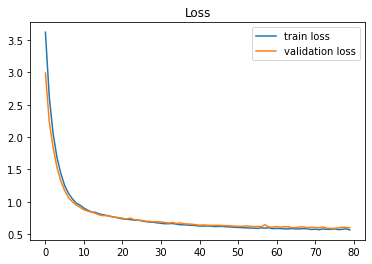

AUC 0.7717118256470671


 20%|████████████████▌                                                                  | 2/10 [00:14<00:55,  6.89s/it]

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_161 (Dense)               (None, 128)          38656       input_33[0][0]                   
__________________________________________________________________________________________________
dropout_65 (Dropout)            (None, 128)          0           dense_161[0][0]                  
__________________________________________________________________________________________________
dense_162 (Dense)               (None, 128)          16512       dropout_65[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 23us/step - loss: 0.6793 - acc: 0.7261 - auc_32: 0.7353 - val_loss: 0.6910 - val_acc: 0.7200 - val_auc_32: 0.7358
Epoch 33/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6720 - acc: 0.7307 - auc_32: 0.7364 - val_loss: 0.6732 - val_acc: 0.7314 - val_auc_32: 0.7369
Epoch 34/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6709 - acc: 0.7268 - auc_32: 0.7375 - val_loss: 0.6743 - val_acc: 0.7214 - val_auc_32: 0.7379
Epoch 35/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.6622 - acc: 0.7271 - auc_32: 0.7385 - val_loss: 0.6707 - val_acc: 0.7229 - val_auc_32: 0.7390
Epoch 36/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6600 - acc: 0.7282 - auc_32: 0.7396 - val_loss: 0.6623 - val_acc: 0.7314 - val_auc_32: 0.7401
Epoch 37/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6588 - acc: 0.7282 - auc_32: 0.7404 - val_loss: 0.67

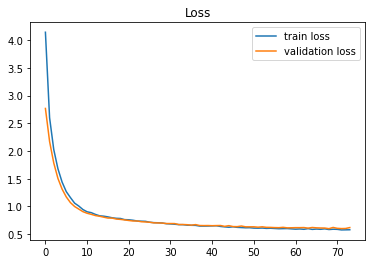

AUC 0.7510939271541951


 30%|████████████████████████▉                                                          | 3/10 [00:22<00:49,  7.14s/it]

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_166 (Dense)               (None, 128)          38656       input_34[0][0]                   
__________________________________________________________________________________________________
dropout_67 (Dropout)            (None, 128)          0           dense_166[0][0]                  
__________________________________________________________________________________________________
dense_167 (Dense)               (None, 128)          16512       dropout_67[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 22us/step - loss: 0.6271 - acc: 0.7343 - auc_33: 0.7491 - val_loss: 0.6747 - val_acc: 0.7186 - val_auc_33: 0.7496
Epoch 33/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6300 - acc: 0.7171 - auc_33: 0.7499 - val_loss: 0.6720 - val_acc: 0.7114 - val_auc_33: 0.7502
Epoch 34/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6142 - acc: 0.7368 - auc_33: 0.7506 - val_loss: 0.6836 - val_acc: 0.6871 - val_auc_33: 0.7510
Epoch 35/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6196 - acc: 0.7293 - auc_33: 0.7514 - val_loss: 0.6577 - val_acc: 0.7171 - val_auc_33: 0.7516
Epoch 36/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6215 - acc: 0.7196 - auc_33: 0.7520 - val_loss: 0.6663 - val_acc: 0.6943 - val_auc_33: 0.7521
Epoch 37/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6196 - acc: 0.7189 - auc_33: 0.7523 - val_loss: 0.65

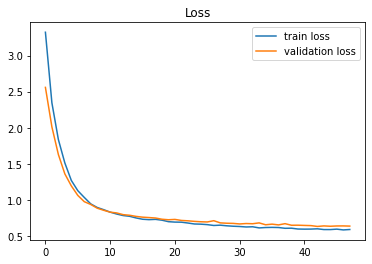

AUC

 40%|█████████████████████████████████▏                                                 | 4/10 [00:27<00:40,  6.68s/it]

 0.7414814814814815
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_171 (Dense)               (None, 128)          38656       input_35[0][0]                   
__________________________________________________________________________________________________
dropout_69 (Dropout)            (None, 128)          0           dense_171[0][0]                  
__________________________________________________________________________________________________
dense_172 (Dense)               (None, 128)          16512       dropout_69[0][0]                 
_______________________________________________________________________

2800/2800 [==============================] - 0s 25us/step - loss: 0.6928 - acc: 0.7246 - auc_34: 0.7329 - val_loss: 0.7226 - val_acc: 0.7214 - val_auc_34: 0.7334
Epoch 33/1000
2800/2800 [==============================] - 0s 29us/step - loss: 0.6857 - acc: 0.7221 - auc_34: 0.7340 - val_loss: 0.7095 - val_acc: 0.7200 - val_auc_34: 0.7346
Epoch 34/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6822 - acc: 0.7175 - auc_34: 0.7351 - val_loss: 0.7014 - val_acc: 0.7257 - val_auc_34: 0.7357
Epoch 35/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6791 - acc: 0.7207 - auc_34: 0.7362 - val_loss: 0.6935 - val_acc: 0.7186 - val_auc_34: 0.7367
Epoch 36/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6717 - acc: 0.7304 - auc_34: 0.7372 - val_loss: 0.6848 - val_acc: 0.7314 - val_auc_34: 0.7377
Epoch 37/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6704 - acc: 0.7329 - auc_34: 0.7382 - val_loss: 0.68

2800/2800 [==============================] - 0s 26us/step - loss: 0.5762 - acc: 0.7261 - auc_34: 0.7590 - val_loss: 0.6146 - val_acc: 0.7157 - val_auc_34: 0.7591
Epoch 79/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5741 - acc: 0.7314 - auc_34: 0.7593 - val_loss: 0.6092 - val_acc: 0.7357 - val_auc_34: 0.7594
Epoch 80/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5691 - acc: 0.7400 - auc_34: 0.7596 - val_loss: 0.6138 - val_acc: 0.7143 - val_auc_34: 0.7598


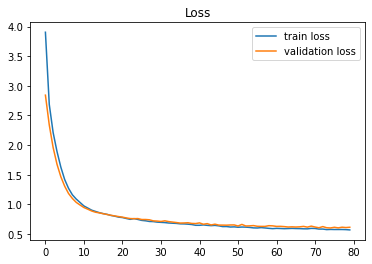

AUC 0.7585864320181663


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:36<00:36,  7.24s/it]

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_176 (Dense)               (None, 128)          38656       input_36[0][0]                   
__________________________________________________________________________________________________
dropout_71 (Dropout)            (None, 128)          0           dense_176[0][0]                  
__________________________________________________________________________________________________
dense_177 (Dense)               (None, 128)          16512       dropout_71[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 20us/step - loss: 0.6983 - acc: 0.7107 - auc_35: 0.7339 - val_loss: 0.6914 - val_acc: 0.7286 - val_auc_35: 0.7344
Epoch 33/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6948 - acc: 0.7132 - auc_35: 0.7349 - val_loss: 0.6916 - val_acc: 0.7171 - val_auc_35: 0.7353
Epoch 34/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6775 - acc: 0.7261 - auc_35: 0.7360 - val_loss: 0.6942 - val_acc: 0.7300 - val_auc_35: 0.7364
Epoch 35/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.6715 - acc: 0.7250 - auc_35: 0.7370 - val_loss: 0.6786 - val_acc: 0.7200 - val_auc_35: 0.7376
Epoch 36/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6720 - acc: 0.7229 - auc_35: 0.7381 - val_loss: 0.6832 - val_acc: 0.7271 - val_auc_35: 0.7386
Epoch 37/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6739 - acc: 0.7246 - auc_35: 0.7390 - val_loss: 0.67

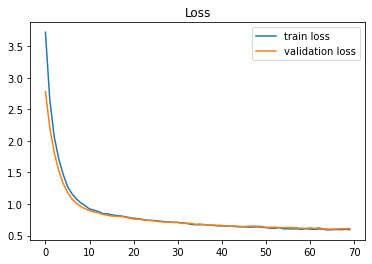

AUC 0.7616564685314685


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:43<00:29,  7.30s/it]

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_181 (Dense)               (None, 128)          38656       input_37[0][0]                   
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 128)          0           dense_181[0][0]                  
__________________________________________________________________________________________________
dense_182 (Dense)               (None, 128)          16512       dropout_73[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 24us/step - loss: 0.6595 - acc: 0.7182 - auc_36: 0.7382 - val_loss: 0.6676 - val_acc: 0.6971 - val_auc_36: 0.7386
Epoch 33/1000
2800/2800 [==============================] - 0s 25us/step - loss: 0.6480 - acc: 0.7275 - auc_36: 0.7391 - val_loss: 0.6679 - val_acc: 0.7143 - val_auc_36: 0.7397
Epoch 34/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.6469 - acc: 0.7186 - auc_36: 0.7402 - val_loss: 0.6638 - val_acc: 0.6957 - val_auc_36: 0.7406
Epoch 35/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6454 - acc: 0.7318 - auc_36: 0.7408 - val_loss: 0.6604 - val_acc: 0.6957 - val_auc_36: 0.7413
Epoch 36/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6416 - acc: 0.7286 - auc_36: 0.7417 - val_loss: 0.6727 - val_acc: 0.6857 - val_auc_36: 0.7420
Epoch 37/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6334 - acc: 0.7304 - auc_36: 0.7424 - val_loss: 0.64

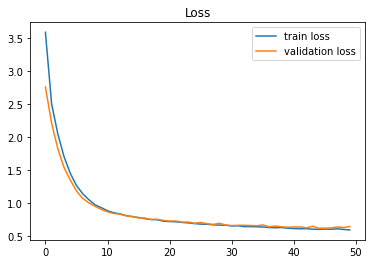

AUC

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:49<00:20,  6.78s/it]

 0.7579368119939723
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_186 (Dense)               (None, 128)          38656       input_38[0][0]                   
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 128)          0           dense_186[0][0]                  
__________________________________________________________________________________________________
dense_187 (Dense)               (None, 128)          16512       dropout_75[0][0]                 
_______________________________________________________________________

2800/2800 [==============================] - 0s 24us/step - loss: 0.6882 - acc: 0.7271 - auc_37: 0.7359 - val_loss: 0.7327 - val_acc: 0.6986 - val_auc_37: 0.7363
Epoch 33/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6760 - acc: 0.7311 - auc_37: 0.7369 - val_loss: 0.7400 - val_acc: 0.6957 - val_auc_37: 0.7374
Epoch 34/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6810 - acc: 0.7300 - auc_37: 0.7379 - val_loss: 0.7218 - val_acc: 0.7043 - val_auc_37: 0.7382
Epoch 35/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6728 - acc: 0.7364 - auc_37: 0.7385 - val_loss: 0.7215 - val_acc: 0.6943 - val_auc_37: 0.7390
Epoch 36/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6690 - acc: 0.7300 - auc_37: 0.7394 - val_loss: 0.7290 - val_acc: 0.6714 - val_auc_37: 0.7398
Epoch 37/1000
2800/2800 [==============================] - 0s 24us/step - loss: 0.6618 - acc: 0.7311 - auc_37: 0.7402 - val_loss: 0.71

2800/2800 [==============================] - 0s 23us/step - loss: 0.5649 - acc: 0.7436 - auc_37: 0.7578 - val_loss: 0.6362 - val_acc: 0.6900 - val_auc_37: 0.7580
Epoch 79/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.5778 - acc: 0.7321 - auc_37: 0.7582 - val_loss: 0.6345 - val_acc: 0.6929 - val_auc_37: 0.7582
Epoch 80/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5758 - acc: 0.7304 - auc_37: 0.7583 - val_loss: 0.6408 - val_acc: 0.6829 - val_auc_37: 0.7584
Epoch 81/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5682 - acc: 0.7386 - auc_37: 0.7585 - val_loss: 0.6286 - val_acc: 0.6957 - val_auc_37: 0.7587
Epoch 82/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5695 - acc: 0.7404 - auc_37: 0.7588 - val_loss: 0.6357 - val_acc: 0.6900 - val_auc_37: 0.7589
Epoch 83/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.5705 - acc: 0.7361 - auc_37: 0.7590 - val_loss: 0.63

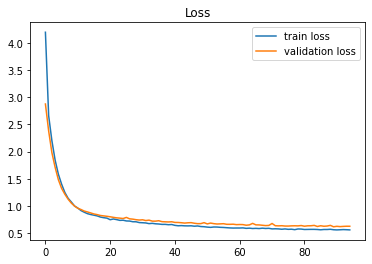

AUC 0.7436382056717663


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:58<00:14,  7.47s/it]

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_191 (Dense)               (None, 128)          38656       input_39[0][0]                   
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 128)          0           dense_191[0][0]                  
__________________________________________________________________________________________________
dense_192 (Dense)               (None, 128)          16512       dropout_77[0][0]                 
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 22us/step - loss: 0.6355 - acc: 0.7232 - auc_38: 0.7466 - val_loss: 0.6782 - val_acc: 0.7100 - val_auc_38: 0.7469
Epoch 33/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.6327 - acc: 0.7261 - auc_38: 0.7473 - val_loss: 0.6862 - val_acc: 0.7100 - val_auc_38: 0.7477
Epoch 34/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6235 - acc: 0.7225 - auc_38: 0.7481 - val_loss: 0.6784 - val_acc: 0.7257 - val_auc_38: 0.7485
Epoch 35/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6204 - acc: 0.7200 - auc_38: 0.7490 - val_loss: 0.6660 - val_acc: 0.7186 - val_auc_38: 0.7493
Epoch 36/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6180 - acc: 0.7239 - auc_38: 0.7497 - val_loss: 0.6690 - val_acc: 0.7143 - val_auc_38: 0.7500
Epoch 37/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.6110 - acc: 0.7243 - auc_38: 0.7505 - val_loss: 0.65

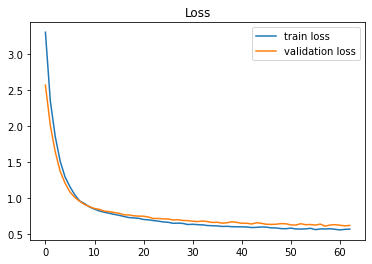

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:05<00:07,  7.22s/it]

AUC 0.7465292257436753
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
dense_196 (Dense)               (None, 128)          38656       input_40[0][0]                   
__________________________________________________________________________________________________
dropout_79 (Dropout)            (None, 128)          0           dense_196[0][0]                  
__________________________________________________________________________________________________
dense_197 (Dense)               (None, 128)          16512       dropout_79[0][0]                 
____________________________________________________________________

2800/2800 [==============================] - 0s 24us/step - loss: 0.6773 - acc: 0.7236 - auc_39: 0.7406 - val_loss: 0.6999 - val_acc: 0.7129 - val_auc_39: 0.7410
Epoch 33/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6784 - acc: 0.7268 - auc_39: 0.7414 - val_loss: 0.6980 - val_acc: 0.7100 - val_auc_39: 0.7418
Epoch 34/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6669 - acc: 0.7250 - auc_39: 0.7422 - val_loss: 0.6984 - val_acc: 0.7086 - val_auc_39: 0.7426
Epoch 35/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.6629 - acc: 0.7250 - auc_39: 0.7429 - val_loss: 0.6868 - val_acc: 0.7271 - val_auc_39: 0.7434
Epoch 36/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6577 - acc: 0.7221 - auc_39: 0.7437 - val_loss: 0.6840 - val_acc: 0.7214 - val_auc_39: 0.7442
Epoch 37/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.6577 - acc: 0.7186 - auc_39: 0.7445 - val_loss: 0.68

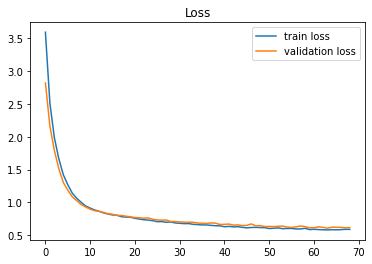

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.35s/it]

AUC 0.7696728220059765


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]


Validation Summary:
1    0.771712
9    0.769673
5    0.761656
0    0.760754
4    0.758586
6    0.757937
2    0.751094
8    0.746529
7    0.743638
3    0.741481
dtype: float64
mean=0.75631, std=0.010


In [16]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    # Define the Model architecture
    input = Input(shape=(X_train.shape[1],)) 
    x = Dense(128, activation='elu', input_shape=(max_features,), kernel_regularizer='l2', kernel_initializer='he_normal')(input) 
    x = Dropout(0.2)(x)
    x1 = Dense(128)(x)
    x = Add()([x1, x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.2)(x)
    x1 = Dense(16)(x)
    x = Add()([x1, x])
    #x = PReLU()(x)
    #x = BatchNormalization()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.AUC()])

    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5),
                 keras.callbacks.ModelCheckpoint(filepath='best_model4.h5',
                                                 monitor='val_loss',
                                                 save_best_only=True)]

    history = model.fit(train_x, train_y, epochs=1000, batch_size=128, 
                        validation_data=(valid_x, valid_y), callbacks=callbacks)

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())

print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 802)          0           input_63[0][0]                   
                                                                 input_64[0][0]                   
__________________________________________________________________________________________________
dense_317 (Dense)               (None, 8)            6424        concatenate_11[0][0]      

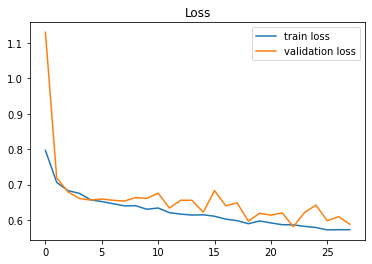

AUC

 10%|████████▎                                                                          | 1/10 [00:03<00:35,  3.90s/it]

 0.7582190758096108
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 802)          0           input_65[0][0]                   
                                                                 input_66[0][0]                   
__________________________________________________________________________________________________
dense_328 (Dense)               (None, 8)            6424        concat

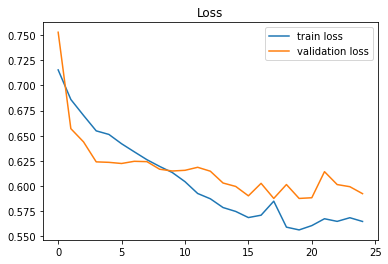

AUC 0.7191629955947136


 20%|████████████████▌                                                                  | 2/10 [00:07<00:30,  3.81s/it]

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 802)          0           input_67[0][0]                   
                                                                 input_68[0][0]                   
__________________________________________________________________________________________________
dense_339 (Dense)               (None, 8)            6424        concatenate_13[0][0]      

2800/2800 [==============================] - 0s 19us/step - loss: 0.5508 - acc: 0.7239 - auc_52: 0.7131 - val_loss: 0.5505 - val_acc: 0.7229 - val_auc_52: 0.7141
Epoch 33/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5511 - acc: 0.7150 - auc_52: 0.7150 - val_loss: 0.5622 - val_acc: 0.7143 - val_auc_52: 0.7159
Epoch 34/1000
2800/2800 [==============================] - 0s 20us/step - loss: 0.5533 - acc: 0.7207 - auc_52: 0.7167 - val_loss: 0.5508 - val_acc: 0.7143 - val_auc_52: 0.7176
Epoch 35/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5529 - acc: 0.7175 - auc_52: 0.7184 - val_loss: 0.5789 - val_acc: 0.6786 - val_auc_52: 0.7191
Epoch 36/1000
2800/2800 [==============================] - 0s 19us/step - loss: 0.5443 - acc: 0.7282 - auc_52: 0.7198 - val_loss: 0.5501 - val_acc: 0.7314 - val_auc_52: 0.7207
Epoch 37/1000
2800/2800 [==============================] - 0s 20us/step - loss: 0.5521 - acc: 0.7225 - auc_52: 0.7215 - val_loss: 0.55

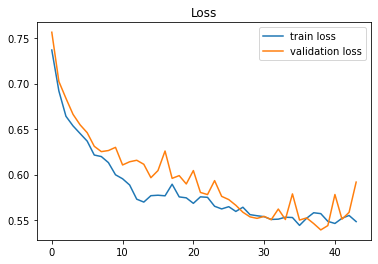

AUC 0.7541021183105414


 30%|████████████████████████▉                                                          | 3/10 [00:12<00:29,  4.16s/it]

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 802)          0           input_69[0][0]                   
                                                                 input_70[0][0]                   
__________________________________________________________________________________________________
dense_350 (Dense)               (None, 8)            6424        concatenate_14[0][0]      

Epoch 32/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.5720 - acc: 0.7014 - auc_53: 0.6846 - val_loss: 0.6051 - val_acc: 0.6729 - val_auc_53: 0.6854
Epoch 33/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5683 - acc: 0.7061 - auc_53: 0.6864 - val_loss: 0.5990 - val_acc: 0.6800 - val_auc_53: 0.6871
Epoch 34/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5617 - acc: 0.7129 - auc_53: 0.6882 - val_loss: 0.6247 - val_acc: 0.6543 - val_auc_53: 0.6890
Epoch 35/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5596 - acc: 0.7100 - auc_53: 0.6896 - val_loss: 0.5913 - val_acc: 0.6900 - val_auc_53: 0.6906


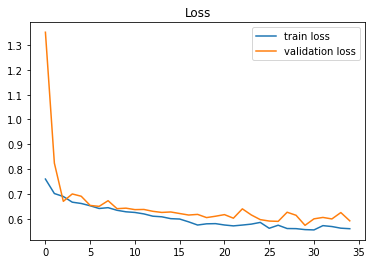

AUC 0.7526734430874534


 40%|█████████████████████████████████▏                                                 | 4/10 [00:16<00:25,  4.24s/it]

Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 802)          0           input_71[0][0]                   
                                                                 input_72[0][0]                   
__________________________________________________________________________________________________
dense_361 (Dense)               (None, 8)            6424        concatenate_15[0][0]      

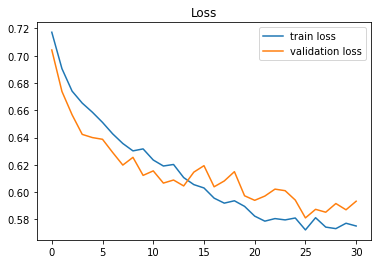

AUC 0.7495498502428614


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:21<00:21,  4.33s/it]

Model: "model_56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 802)          0           input_73[0][0]                   
                                                                 input_74[0][0]                   
__________________________________________________________________________________________________
dense_372 (Dense)               (None, 8)            6424        concatenate_16[0][0]      

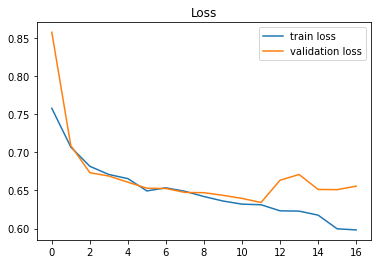

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:24<00:15,  3.96s/it]

AUC 0.7042249815847628
Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_76 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 802)          0           input_75[0][0]                   
                                                                 input_76[0][0]                   
__________________________________________________________________________________________________
dense_383 (Dense)               (None, 8)            6424        con

2800/2800 [==============================] - 0s 20us/step - loss: 0.5727 - acc: 0.6975 - auc_56: 0.6519 - val_loss: 0.5881 - val_acc: 0.6686 - val_auc_56: 0.6536
Epoch 33/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5669 - acc: 0.7079 - auc_56: 0.6553 - val_loss: 0.5887 - val_acc: 0.6671 - val_auc_56: 0.6569
Epoch 34/1000
2800/2800 [==============================] - 0s 23us/step - loss: 0.5657 - acc: 0.7096 - auc_56: 0.6585 - val_loss: 0.5769 - val_acc: 0.6800 - val_auc_56: 0.6600
Epoch 35/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5687 - acc: 0.7093 - auc_56: 0.6613 - val_loss: 0.5848 - val_acc: 0.6557 - val_auc_56: 0.6628
Epoch 36/1000
2800/2800 [==============================] - 0s 22us/step - loss: 0.5672 - acc: 0.7146 - auc_56: 0.6642 - val_loss: 0.5818 - val_acc: 0.7000 - val_auc_56: 0.6655
Epoch 37/1000
2800/2800 [==============================] - 0s 21us/step - loss: 0.5659 - acc: 0.7079 - auc_56: 0.6667 - val_loss: 0.58

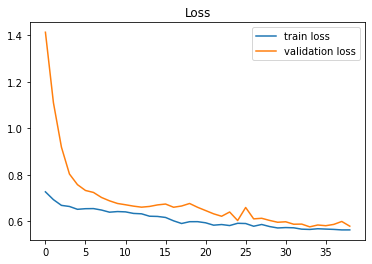

AUC 0.7491032952287564


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:29<00:12,  4.19s/it]

Model: "model_58"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_78 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 802)          0           input_77[0][0]                   
                                                                 input_78[0][0]                   
__________________________________________________________________________________________________
dense_394 (Dense)               (None, 8)            6424        concatenate_18[0][0]      

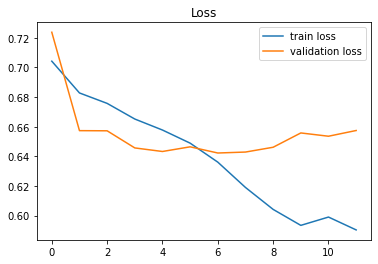

AUC 0.6376961876232173


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:31<00:07,  3.71s/it]

Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_80 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 802)          0           input_79[0][0]                   
                                                                 input_80[0][0]                   
__________________________________________________________________________________________________
dense_405 (Dense)               (None, 8)            6424        concatenate_19[0][0]      

Epoch 32/1000
2800/2800 [==============================] - 0s 20us/step - loss: 0.5866 - acc: 0.6739 - auc_58: 0.6713 - val_loss: 0.5902 - val_acc: 0.7043 - val_auc_58: 0.6724
Epoch 33/1000
2800/2800 [==============================] - 0s 20us/step - loss: 0.5843 - acc: 0.6718 - auc_58: 0.6732 - val_loss: 0.6095 - val_acc: 0.6443 - val_auc_58: 0.6741
Epoch 34/1000
2800/2800 [==============================] - 0s 20us/step - loss: 0.5816 - acc: 0.6807 - auc_58: 0.6748 - val_loss: 0.5887 - val_acc: 0.6971 - val_auc_58: 0.6759
Epoch 35/1000
2800/2800 [==============================] - 0s 19us/step - loss: 0.5790 - acc: 0.6854 - auc_58: 0.6770 - val_loss: 0.5859 - val_acc: 0.6914 - val_auc_58: 0.6780
Epoch 36/1000
2800/2800 [==============================] - 0s 20us/step - loss: 0.5881 - acc: 0.6693 - auc_58: 0.6787 - val_loss: 0.6104 - val_acc: 0.6443 - val_auc_58: 0.6791
Epoch 37/1000
2800/2800 [==============================] - 0s 19us/step - loss: 0.5850 - acc: 0.6736 - auc_58: 0.6795 - 

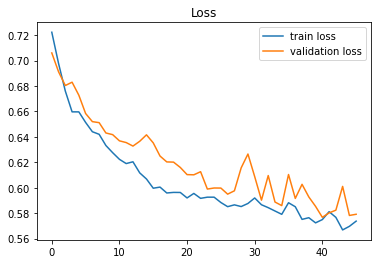

AUC

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:36<00:04,  4.12s/it]

 0.7642846577511725
Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, 301)          0                                            
__________________________________________________________________________________________________
input_82 (InputLayer)           (None, 501)          0                                            
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 802)          0           input_81[0][0]                   
                                                                 input_82[0][0]                   
__________________________________________________________________________________________________
dense_416 (Dense)               (None, 8)            6424        concat

2800/2800 [==============================] - 0s 19us/step - loss: 0.5840 - acc: 0.6871 - auc_59: 0.6716 - val_loss: 0.5863 - val_acc: 0.7071 - val_auc_59: 0.6728


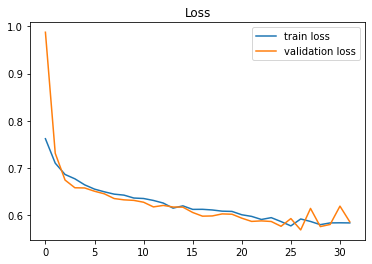

AUC 0.762932099855231


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.12s/it]


Validation Summary:
8    0.764285
9    0.762932
0    0.758219
2    0.754102
3    0.752673
4    0.749550
6    0.749103
1    0.719163
5    0.704225
7    0.637696
dtype: float64
mean=0.73519, std=0.039


In [19]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    # Define the Model architecture
    input_W1 = Input(shape=(X_train.shape[1],)) 
    x = Dense(128, activation='elu', input_shape=(max_features,), kernel_regularizer='l2', kernel_initializer='he_normal')(input_W1) 
    x = Dropout(0.2)(x)
    x1 = Dense(128)(x)
    x = Add()([x1, x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.2)(x)
    x1 = Dense(16)(x)
    node1 = Add()([x1, x])
    
    input_W2 = Input(shape=(X2_train.shape[1],)) 
    x = Dense(128, activation='elu', input_shape=(max_features,), kernel_regularizer='l2', kernel_initializer='he_normal')(input_W2) 
    x = Dropout(0.1)(x)
    x1 = Dense(128)(x)
    x = Add()([x1, x])
    x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x1 = Dense(16)(x)
    x = Add()([x1, x])
    #x = PReLU()(x)
    node2 = BatchNormalization()(x)
    
    x = keras.layers.concatenate([input_W1, input_W2])
    x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x1 = Dense(128)(x)
    x = Add()([x1, x])
    #x = PReLU()(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation='sigmoid')(x)

    model_F = Model([input_W1,input_W2], out)
    model_F.summary()

    # Train the Model
    model_F.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.AUC()])

    train_x, valid_x, train_x2, valid_x2, train_y, valid_y = train_test_split(X_train, X2_train, y_train, test_size=0.2)

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5),
                 keras.callbacks.ModelCheckpoint(filepath='best_model4.h5',
                                                 monitor='val_loss',
                                                 save_best_only=True)]

    history = model_F.fit([train_x,train_x2], train_y, epochs=1000, batch_size=128, 
                        validation_data=([valid_x,valid_x2], valid_y), callbacks=callbacks)

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    auc = roc_auc_score(valid_y, model_F.predict([valid_x,valid_x2]).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model_F.predict([X_test,X2_test]).flatten())

print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               77056     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

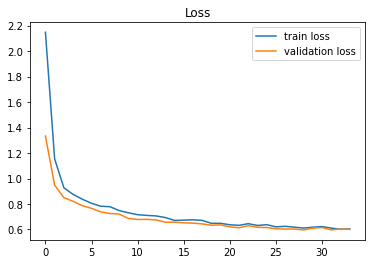

In [33]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(max_features,), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.summary()

# Train the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, callbacks=callbacks)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [34]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Submission

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Submission


In [35]:
pred = model.predict(X_test)[:,0]
t = pd.Timestamp.now()
fname = f"NN_submission_F5_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'NN_submission_F5_06102002.csv' is ready to submit.
